# Conversion polar $\leftrightarrow$ pseudopolar coordinates

Method found in https://www.cs.tau.ac.il/~amir1/PS/30_PolarFFT_ACHA.pdf 

Let $I : \mathcal{D}(n)^2 \to \mathbb{C}$ be an input image of size $n \times n$. We recall that the pseudo-polar grids are defined as:
$$
\text{Basically horizontal lines: } \Omega_h = \left\{ \left(- \frac{2l}{n}k, k \right) \mid l \in \llbracket - \frac{n}{2}, \frac{n}{2} \rrbracket, \, k \in \llbracket -n, n \rrbracket \right\} \\
\text{Basically vertical lines: } \Omega_v = \left\{ \left(k, - \frac{2l}{n}k \right) \mid l \in \llbracket - \frac{n}{2}, \frac{n}{2} \rrbracket, \, k \in \llbracket -n, n \rrbracket \right\}
$$

The horizontal and vertical pseudo-polar Fourier transforms evaluate the following trigonometric polynomial:
$$
P(x, y) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \left[ux + vy \right]\right)
$$

at the frequencies given by $\Omega_h$ and $\Omega_v$. Visually, the set $\Omega_h \cup \Omega_v$ contains:
- the center $(0, 0)$
- the intersection of $n$ concentric squares by $2n$ sloped-equispaced rays

On the other hand, the polar Fourier transform frequencies are:
$$
\left\{ \left( p \cos\left( \frac{\pi q}{2n} \right), p \sin\left( \frac{\pi q}{2n} \right) \right) \mid p \in \llbracket -n, n \rrbracket, q \in \llbracket 0, 2n-1 \rrbracket \right\}
$$



In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize the grids

In [60]:
def horizontal_lines(n: int):
    coords = np.empty(shape=(n + 1, 2 * n + 1, 2))

    for l in range(n + 1):
        for k in range(2 * n + 1):
            coords[l, k, 0] = -2 * (l - n//2) * (k - n) / n
            coords[l, k, 1] = k - n

    return coords

def vertical_lines(n: int):
    coords = np.empty(shape=(n + 1, 2 * n + 1, 2))

    for l in range(n + 1):
        for k in range(2 * n + 1):
            coords[l, k, 0] = k - n
            coords[l, k, 1] = -2 * (l - n//2) * (k - n) / n

    return coords

def polar_coordinates(n: int):
    p = np.arange(-n, n + 1)
    q = np.arange(0, 2 * n)

    x = p[:, None] * np.cos(np.pi * q / (2 * n))[None, :]
    y = p[:, None] * np.sin(np.pi * q / (2 * n))[None, :]

    return np.stack((x, y), axis=-1)

In [61]:
hori_coords = horizontal_lines(10)
hori_x_coords = hori_coords[..., 0]
hori_y_coords = hori_coords[..., 1]

vert_coords = vertical_lines(10)
vert_x_coords = vert_coords[..., 0]
vert_y_coords = vert_coords[..., 1]

polar_coords = polar_coordinates(10)
polar_x, polar_y = polar_coords[..., 0], polar_coords[..., 1]

[]

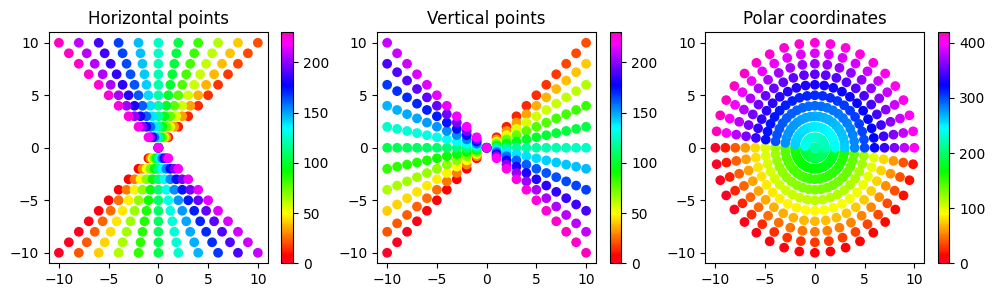

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

im = axes[0].scatter(hori_x_coords.flatten(), hori_y_coords.flatten(),
            c=np.arange(hori_x_coords.size), cmap='gist_rainbow')
axes[0].set_title("Horizontal points")
plt.colorbar(im, ax=axes[0])

im = axes[1].scatter(vert_x_coords.flatten(), vert_y_coords.flatten(),
            c=np.arange(vert_x_coords.size), cmap='gist_rainbow')
axes[1].set_title("Vertical points")
plt.colorbar(im, ax=axes[1])

im = axes[2].scatter(polar_x.flatten(), polar_y.flatten(),
            c=np.arange(polar_x.size), cmap='gist_rainbow')
axes[2].set_title("Polar coordinates")
plt.colorbar(im, ax=axes[2])

plt.plot()

We can see that the polar coordinates lack samples in the corners. In the paper, the assume that the samples in those regions are equal to 0.

# Recovering the pseudo-polar Fourier transform from the polar Fourier transform

We assume the polar Fourier transform are stored in a $2n + 1 \times 2n$ array $P$, such that:
$$
\forall p \in \llbracket -n, n \rrbracket, \forall q \in \llbracket 0, 2n-1 \rrbracket, P[p, q] = \widehat{I}\left( p \cos\left( \frac{\pi q}{2n} \right), p \sin\left( \frac{\pi q}{2n} \right) \right) 
$$

The first step is to do an interpolation along each ray. Let $q \in \llbracket 0, 2n-1 \rrbracket$ be a ray. If $q \in \llbracket 0, \frac{n}{2} \rrbracket \cup \llbracket n + \frac{n}{2}, 2n - 1\rrbracket$ then this ray "corresponds" to a ray of the vertical pseudo-polar Fourier transform. We want to interpolate the values of this ray to the $x$ coordinates of the vertical pseudo-polar Fourier transform, which are $\llbracket -n, n \rrbracket$.

On this line, two consecutive points are separated by a distance $d = 1$.

In [63]:
from scipy.interpolate import interp1d

In [64]:
def interpolate_vert_ray(q, ray_samples, kind='linear'):
    """
    Interpolate rays corresponding to the vertical PPFFT.
    0 <= q <= n/2 or n + n/2 <= q <= 2n - 1

    ``ray_samples`` always goes from the bottom of the circle to the top.
    """
    n = (len(ray_samples) - 1) // 2

    ray_pos = np.arange(-n, n + 1) # positions of the known points along the line
    theta = np.pi * q / (2 * n)
    target_pos = np.arange(-n, n + 1) * np.sqrt(1 + np.tan(theta)**2)

    # Interpolate and put zeros outside of the polar disk
    interpolator = interp1d(ray_pos, ray_samples, bounds_error=False, fill_value=0, kind=kind)

    if 0 <= q <= n//2:
        res = interpolator(target_pos)
    else:
        res = interpolator(target_pos)[::-1]

    return res


def interpolate_all_vert_rays(polar_ft, kind='linear'):
    """
    Computes the first step towards the vertical PPFFT.
    """
    n = np.shape(polar_ft)[1] // 2

    res = np.zeros(shape=(2 * n + 1, n + 1), dtype=complex)

    i = 0
    for q in range(n + n//2, 2 * n):
        res[:, i] = interpolate_vert_ray(q, polar_ft[:, q], kind)
        i += 1

    res[:, i] = polar_ft[:, 0] # theta = 0, horizontal coordinates
    i += 1

    for q in range(1, n//2 + 1):
        res[:, i] = interpolate_vert_ray(q, polar_ft[:, q], kind)
        i += 1

    return res[::, ::-1]


def interpolate_hori_ray(q, ray_samples, kind='linear'):
    """
    Interpolate rays corresponding to the horizontal PPFFT.
    n/2 <= q <= n + n/2
    """
    n = (len(ray_samples) - 1) // 2
    
    ray_pos = np.arange(-n, n + 1) # positions of the known points along the line
    theta = np.pi * q / (2 * n)
    target_pos = np.arange(-n, n + 1) * np.sqrt(1 + 1 / np.tan(theta)**2)
    
    # Interpolate and put zeros outside of the polar disk
    interpolator = interp1d(ray_pos, ray_samples, bounds_error=False, fill_value=0, kind=kind)

    return interpolator(target_pos)


def interpolate_all_hori_rays(polar_ft, kind='linear'):
    """
    Computes the first step towards the horizontal PPFFT.
    """
    n = np.shape(polar_ft)[1] // 2

    res = np.zeros(shape=(2 * n + 1, n + 1), dtype=complex)

    i = 0

    for q in range(n//2, n):
        res[:, i] = interpolate_hori_ray(q, polar_ft[:, q], kind)
        i += 1

    res[:, i] = polar_ft[:, n]
    i += 1

    for q in range(n + 1, n + n//2 + 1):
        res[:, i] = interpolate_hori_ray(q, polar_ft[:, q], kind)
        i += 1

    return res


In [65]:
def interpolate_vert_angle(k, samples, kind='linear'):
    """
    Reconstruct one column of the horizontal PPFFT.
    -n <= k <= n
    """
    n = len(samples) - 1

    # samples at x = k
    # and angles pi * q / 2n with q = n/2, ... 0, 2n-1, ..., n + n/2
    # meaning the y positions are: x_q = k * tan(theta_q)
    q = np.concatenate((np.arange(0, n//2 + 1)[::-1], np.arange(n + n//2, 2 * n)[::-1]))
    samples_pos = k * np.tan(np.pi * q / (2 * n))

    # Initialize interpolator
    interpolator = interp1d(samples_pos, samples, kind=kind)

    # The target y positions are: y_l = -2lk / n with -n/2 <= l <= n/2
    target_pos = np.arange(-(n//2), n//2 + 1) * (-2 * k / n)

    # Compute result
    res = np.zeros_like(target_pos, dtype=complex)
    res[1:-1] = interpolator(target_pos[1:-1])
    res[0] = samples[0]
    res[-1] = samples[-1]

    return res


def interpolate_hori_angle(k, samples, kind='linear'):
    """
    Reconstruct one line of the horizontal PPFFT.
    -n <= k <= n
    """
    n = len(samples) - 1

    # samples at y = k
    # and angles pi * q / 2n with n/2 <= q <= n + n/2
    # meaning the x positions are: x_q = k / tan(theta_q)
    samples_pos = k / np.tan(np.pi * np.arange(n//2, n + n//2 + 1) / (2 * n))

    # Initialize interpolator
    interpolator = interp1d(samples_pos, samples, kind=kind)

    # The target x positions are: x_l = -2lk / n with -n/2 <= l <= n/2
    target_pos = np.arange(-(n//2), n//2 + 1) * (-2 * k / n)

    # Compute result
    res = np.zeros_like(target_pos, dtype=complex)
    res[0] = samples[0] # the first point is already known
    res[-1] = samples[-1] # the last one too
    res[1:-1] = interpolator(target_pos[1:-1])

    return res
    

def interpolate_all_vert_angles(vert_rays, kind='linear'):
    """
    ``vert_rays`` is the ouput of ``interpolate_all_vert_rays``.
    Its shape is (2n+1, n+1)
    """
    n = np.shape(vert_rays)[1] - 1
    vert_ppfft = np.zeros_like(vert_rays, dtype=complex)

    for k in np.arange(-n, n + 1):
        if k != 0:
            samples = vert_rays[k + n]
            vert_ppfft[k + n] = interpolate_vert_angle(k, samples, kind)
        else:
            vert_ppfft[k + n] = vert_rays[k + n]

    return vert_ppfft.T


def interpolate_all_hori_angles(hori_rays, kind='linear'):
    """
    ``hori_rays`` is the ouput of ``interpolate_all_hori_rays``.
    Its shape is (2n+1, n+1)
    """
    n = np.shape(hori_rays)[1] - 1
    hori_ppfft = np.zeros_like(hori_rays, dtype=complex)

    for k in np.arange(-n, n + 1):
        if k != 0:
            samples = hori_rays[k + n]
            hori_ppfft[k + n] = interpolate_vert_angle(k, samples, kind)
        else:
            hori_ppfft[k + n] = hori_rays[k + n]

    return hori_ppfft.T


In [66]:
def polar_to_pseudopolar(polar_ft, kind='linear'):
    vert_rays = interpolate_all_vert_rays(polar_ft, kind)
    hori_rays = interpolate_all_hori_rays(polar_ft, kind)
    vert_ppfft = interpolate_all_vert_angles(vert_rays, kind)
    hori_ppfft = interpolate_all_hori_angles(hori_rays, kind)

    return hori_ppfft, vert_ppfft

# Test

In [67]:
from ppfft import ppfft

In [68]:
def polar_fourier_transform(im):
    n = len(im)
    m = 2 * n + 1
    half_n = n // 2
    p = np.arange(-n, n + 1) / m
    q = np.arange(2 * n)
    u, v = np.arange(-half_n, half_n), np.arange(-half_n, half_n)

    cos = -2j * np.pi * np.einsum("k,u,l->kul", p, u, np.cos(np.pi * q / (2 * n)))
    sin = -2j * np.pi * np.einsum("k,v,l->kvl", p, v, np.sin(np.pi * q / (2 * n)))

    res = np.einsum("uv,kul,kvl->kl", im, np.exp(cos), np.exp(sin))

    return res

In [69]:
n = 20
im = np.random.rand(n, n)
polar_ft = polar_fourier_transform(im)
hori, vert = ppfft(im)

In [70]:
hori_coords = horizontal_lines(n)
hori_x_coords = hori_coords[..., 0]
hori_y_coords = hori_coords[..., 1]

vert_coords = vertical_lines(n)
vert_x_coords = vert_coords[..., 0]
vert_y_coords = vert_coords[..., 1]

polar_coords = polar_coordinates(n)
polar_x, polar_y = polar_coords[..., 0], polar_coords[..., 1]

[]

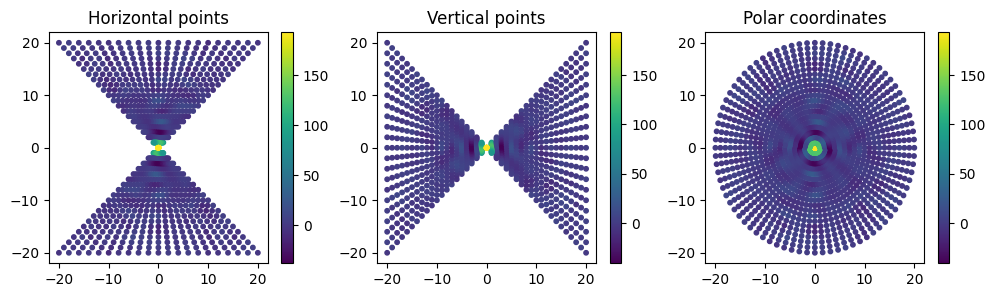

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

im = axes[0].scatter(hori_x_coords.flatten(), hori_y_coords.flatten(), c=hori.flatten(), s=10)
axes[0].set_title("Horizontal points")
plt.colorbar(im, ax=axes[0])

im = axes[1].scatter(vert_x_coords.flatten(), vert_y_coords.flatten(), c=vert.flatten(), s=10)
axes[1].set_title("Vertical points")
plt.colorbar(im, ax=axes[1])

im = axes[2].scatter(polar_x.flatten(), polar_y.flatten(), c=polar_ft.flatten(), s=10)
axes[2].set_title("Polar coordinates")
plt.colorbar(im, ax=axes[2])

plt.plot()

In [72]:
sol_hori, sol_vert = polar_to_pseudopolar(polar_ft, kind='cubic')

[None, None, None, None, None, None]

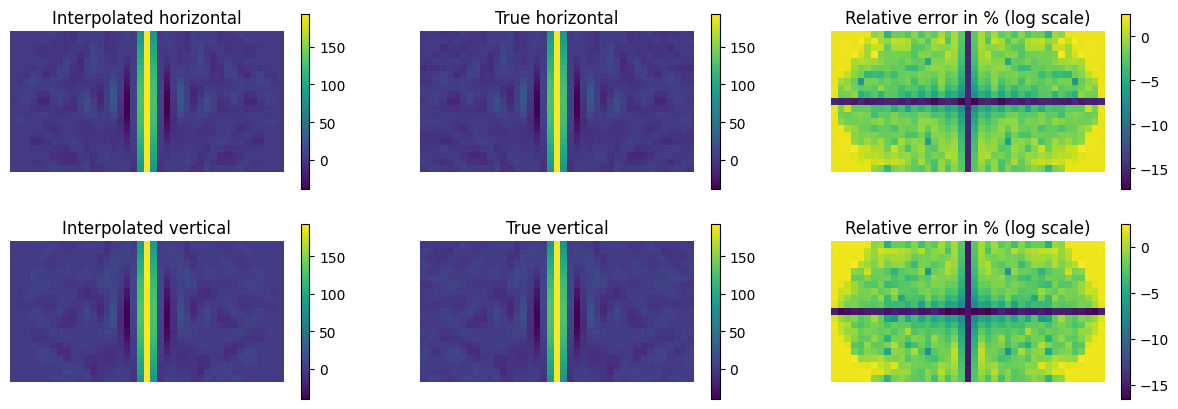

In [73]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

im = axes[0, 0].imshow(sol_hori.real)
plt.colorbar(im, ax=axes[0, 0])
axes[0, 0].set_title("Interpolated horizontal")
im = axes[0, 1].imshow(hori.real)
plt.colorbar(im, ax=axes[0, 1])
axes[0, 1].set_title("True horizontal")
im =axes[0, 2].imshow(2 + np.log(np.abs(sol_hori - hori)) - np.log(np.abs(hori)))
plt.colorbar(im, ax=axes[0, 2])
axes[0, 2].set_title("Relative error in % (log scale)")

im = axes[1, 0].imshow(sol_vert.real)
plt.colorbar(im, ax=axes[1, 0])
axes[1, 0].set_title("Interpolated vertical")
im = axes[1, 1].imshow(vert.real)
plt.colorbar(im, ax=axes[1, 1])
axes[1, 1].set_title("True vertical")
im = axes[1, 2].imshow(2 + np.log(np.abs(sol_vert - vert)) - np.log(np.abs(vert)))
plt.colorbar(im, ax=axes[1, 2])
axes[1, 2].set_title("Relative error in % (log scale)")

[axi.set_axis_off() for axi in axes.ravel()]

# Try full inversion

In [74]:
from direct_inverse import direct_inversion

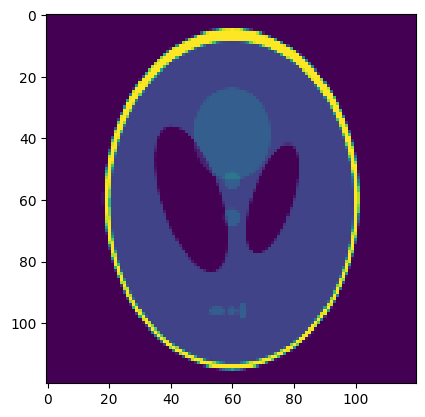

In [75]:
im = plt.imread("Shepp_logan_240.png")
im = im[::2, ::2]
plt.imshow(im)

In [76]:
polar_ft = polar_fourier_transform(im)
hori, vert = polar_to_pseudopolar(polar_ft, kind='cubic')
sol = np.real_if_close(direct_inversion(hori, vert))

[None, None, None]

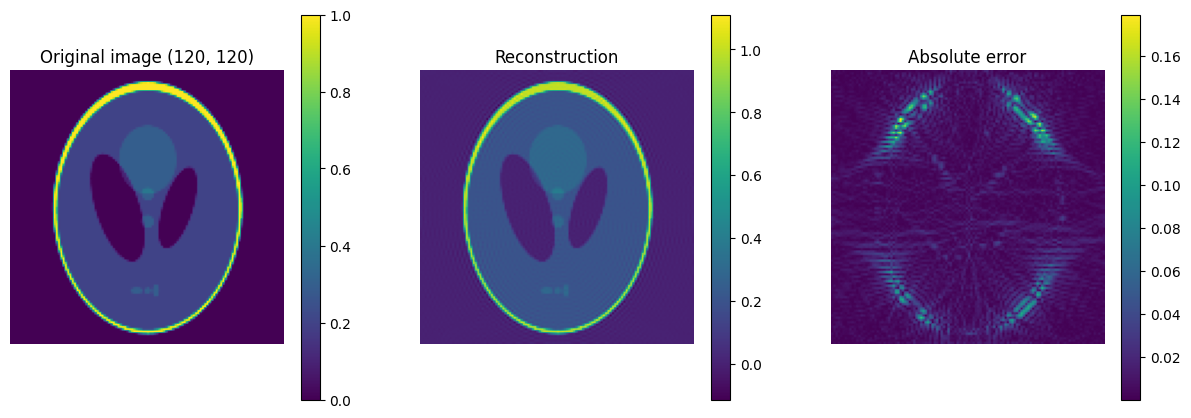

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

a = axes[0].imshow(im)
plt.colorbar(a, ax=axes[0])
axes[0].set_title(f"Original image {im.shape}")
a = axes[1].imshow(sol)
plt.colorbar(a, ax=axes[1])
axes[1].set_title("Reconstruction")

a = axes[2].imshow(np.abs(im - sol))
plt.colorbar(a, ax=axes[2])
axes[2].set_title("Absolute error")

[axi.set_axis_off() for axi in axes.ravel()]

# Try 2D interpolation

In [78]:
from scipy.interpolate import CloughTocher2DInterpolator

In [79]:
def direct_2d_interp(polar_ft, points, n, interp_fun=CloughTocher2DInterpolator):
    interpolator = interp_fun(points, polar_ft, fill_value=0)
    
    hori_pos = horizontal_lines(n)
    vert_pos = vertical_lines(n)
    
    hori_ppfft = interpolator(hori_pos[..., 0], hori_pos[..., 1])
    vert_ppfft = interpolator(vert_pos[..., 0], vert_pos[..., 1])

    return hori_ppfft, vert_ppfft

In [80]:
im = plt.imread("Shepp_logan_240.png")
im = im[::2, ::2]

In [81]:
n = len(im)
polar_ft = polar_fourier_transform(im)
aux = polar_coordinates(n)
positions = np.stack((aux[..., 0].flatten(), aux[..., 1].flatten()), axis=-1)
hori_ppfft, vert_ppfft = direct_2d_interp(polar_ft.flatten(), positions, n)
sol = np.real_if_close(direct_inversion(hori_ppfft, vert_ppfft))

[None, None, None]

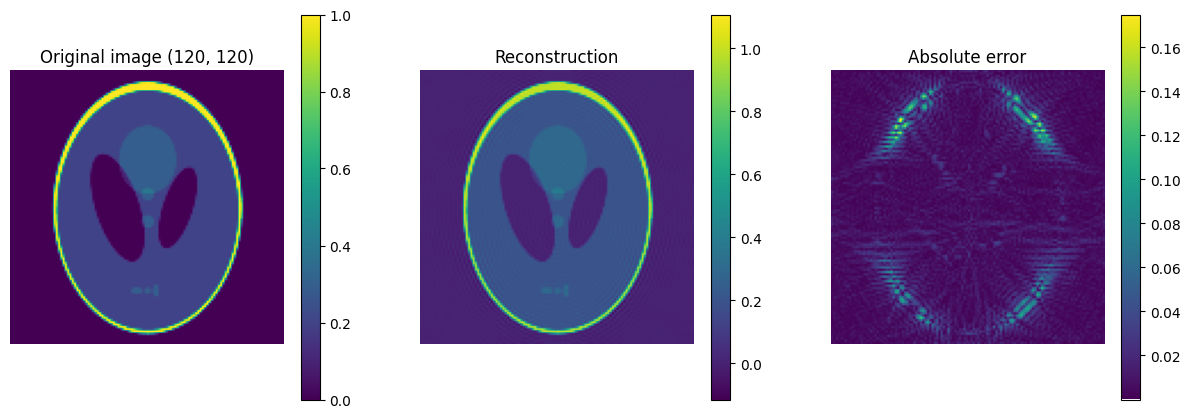

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

a = axes[0].imshow(im)
plt.colorbar(a, ax=axes[0])
axes[0].set_title(f"Original image {im.shape}")
a = axes[1].imshow(sol.real)
plt.colorbar(a, ax=axes[1])
axes[1].set_title("Reconstruction")

a = axes[2].imshow(np.abs(im - sol))
plt.colorbar(a, ax=axes[2])
axes[2].set_title("Absolute error")

[axi.set_axis_off() for axi in axes.ravel()]

In [83]:
im = plt.imread("Shepp_logan_240.png")
im = im[::, ::]

In [84]:
n = len(im)
polar_ft = polar_fourier_transform(im)[:, ::2]
aux = polar_coordinates(n)
positions = np.stack((aux[:, ::2, 0].flatten(), aux[:, ::2, 1].flatten()), axis=-1)
hori_ppfft, vert_ppfft = direct_2d_interp(polar_ft.flatten(), positions, n)
sol = np.real_if_close(direct_inversion(hori_ppfft, vert_ppfft))

[None, None, None]

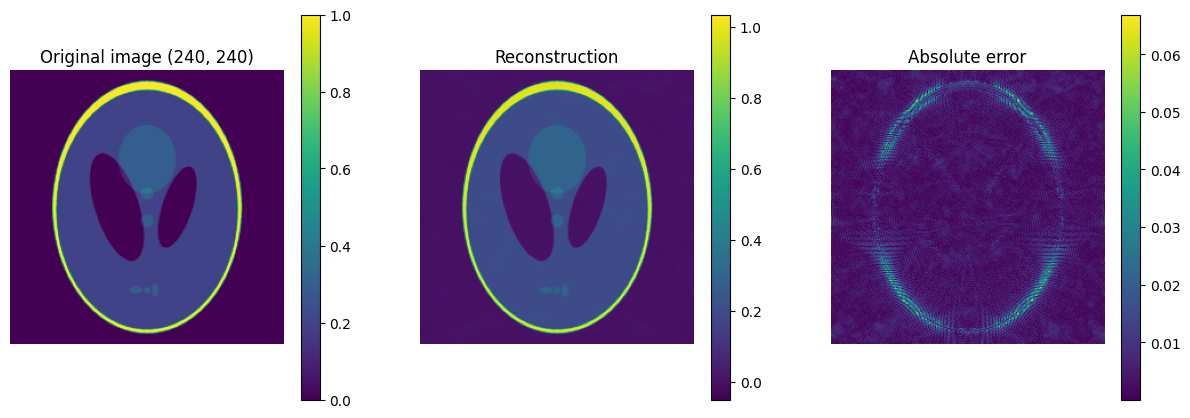

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

a = axes[0].imshow(im)
plt.colorbar(a, ax=axes[0])
axes[0].set_title(f"Original image {im.shape}")
a = axes[1].imshow(sol.real)
plt.colorbar(a, ax=axes[1])
axes[1].set_title("Reconstruction")

a = axes[2].imshow(np.abs(im - sol))
plt.colorbar(a, ax=axes[2])
axes[2].set_title("Absolute error")

[axi.set_axis_off() for axi in axes.ravel()]

# Findings

- The wave artefacts seem to disappear when we take the full image instead of the under-sampled one.
- Using the 2D interpolation with $n$ projections gives the same results as the 1D interpolations with $2n$ projections

# Things we can try

- Other interpolators (regular grid in polar coordinates?)
- Resampling sinogram https://arxiv.org/pdf/1708.05163.pdf
- Improve 1D interpolations using trigonometric polynomials ?...